# Generate state vector netcdf file from shape file

Use this notebook to create an IMI state vector file for an irregular region of interest using a shape file for the region.

- Step 1: Upload the shape file to EC2
- Step 2: Copy the path to the shape file into the configuration file (config.yml)
- Step 3: Open this notebook (instructions: https://docs.aws.amazon.com/dlami/latest/devguide/setup-jupyter.html)
- Step 4: Run the notebook
- Step 5: When satisfied with the state vector, set save switch in final cell to True and save the netcdf

Example here is for the Permian Basin.

In [1]:
import sys
import xarray as xr 
import numpy as np
import regionmask
import xesmf as xe
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
from sklearn.cluster import KMeans
import colorcet as cc
import matplotlib.pyplot as plt
import yaml
import warnings; warnings.filterwarnings(action='ignore')
sys.path.append('/home/ubuntu/integrated_methane_inversion/src/')
from utilities.utils import download_landcover_files
%matplotlib inline

## Setup

In [2]:
# Read config file
config = yaml.load(open("/home/ubuntu/integrated_methane_inversion/config.yml"), Loader=yaml.FullLoader)

In [ ]:
# Download landcover files from s3 if not already present
download_landcover_files(config)

In [3]:
# Set longitude and latitude bounds for inversion domain
lon_min = config['LonMinCustomStateVector']
lon_max = config['LonMaxCustomStateVector']
lat_min = config['LatMinCustomStateVector']
lat_max = config['LatMaxCustomStateVector']

# Create lat/lon grid
dlon = 0.1
dlat = 0.1
lon = np.arange(lon_min, lon_max+dlon, dlon)
lat = np.arange(lat_min, lat_max+dlat, dlat)

# Inversion spatial resolution
if config['Res'] == '0.25x0.3125':
    lat_res = 0.25
    lon_res = 0.3125
elif config['Res'] == '0.5x0.625':
    lat_res = 0.5
    lon_res = 0.625

## Create region of interest mask from shape file

In [4]:
# Open shape file with geopandas
shape = gpd.read_file(config['ShapeFile'])
shape

,geometry
0,"POLYGON ((-100.54152 33.84438, -100.50482 33.6..."


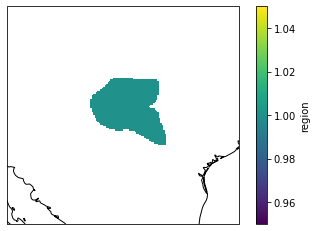

In [5]:
# Make mask from shape file
mask = regionmask.mask_geopandas(shape, lon, lat) + 1 # Add 1 so the mask values are 1 instead of 0

# View the mask in the inversion domain
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
mask.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=True,
)
ax.coastlines();

## Regrid mask to 0.25 x 0.3125 or 0.5x0.625 grid

In [6]:
# Need to regrid to the grid HEMCO expects
reference_lat_grid = np.arange(-90 , 90+lat_res , lat_res)
reference_lon_grid = np.arange(-180, 180+lon_res, lon_res)

# Find closest reference coordinates to selected lat/lon bounds
lat_min = reference_lat_grid[np.abs(reference_lat_grid - lat_min).argmin()]
lon_min = reference_lon_grid[np.abs(reference_lon_grid - lon_min).argmin()]
lat_max = reference_lat_grid[np.abs(reference_lat_grid - lat_max).argmin()]
lon_max = reference_lon_grid[np.abs(reference_lon_grid - lon_max).argmin()]

# Create an xESMF regridder object to resample the mask on the grid HEMCO expects
new_lat_grid = np.arange(lat_min, lat_max+lat_res, lat_res)
new_lon_grid = np.arange(lon_min, lon_max+lon_res, lon_res)
ds_out = xr.Dataset({'lat': (['lat'], new_lat_grid),
                     'lon': (['lon'], new_lon_grid),
                    }
                   )
#ds_out = ds_out.rename({'longitude': 'lon', 'latitude': 'lat'})

regridder = xe.Regridder(mask, ds_out, 'nearest_s2d')
regridder

xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_151x161_61x52.nc 
Reuse pre-computed weights? False 
Input grid shape:           (151, 161) 
Output grid shape:          (61, 52) 
Periodic in longitude?      False

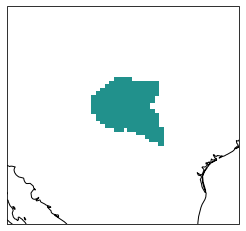

In [7]:
# Regrid the mask
mask = regridder(mask)

# View the regridded mask in the inversion domain
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
mask.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
ax.coastlines();

## Deal with buffer areas and pixels over water

In [8]:
state_vector = mask.copy()

# Set pixels in buffer areas to 0
state_vector.values[mask.isnull()] = 0
state_vector.values[mask.isnull()] = 0

In [9]:
# Get path to land cover file
if config['Met'] == 'geosfp':
    met_token1 = 'GEOSFP'
    met_token2 = 'GEOS_FP'
    constYr = 2011
    gridRes = '025x03125'
elif config['Met'] == 'merra2':
    met_token1 = 'MERRA2'
    met_token2 = 'MERRA2'
    constYr = 2015
    gridRes = '05x0625'

gridDir = f'{config["Res"]}_{config["REGION"]}'
land_cover_file = f'{met_token1}.{constYr}0101.CN.{gridRes}.{config["REGION"]}.nc'
land_cover_pth = f'/home/ubuntu/ExtData/GEOS_{gridDir}/{met_token2}/{constYr}/01/{land_cover_file}'

In [10]:
# Load land cover data
lc = xr.load_dataset(land_cover_pth)

# Group together
lc = (lc['FRLAKE'] + lc['FRLAND'] + lc['FRLANDIC']).drop('time').squeeze()
    
# Subset the area of interest
lc = lc.isel(lon=lc.lon>=lon_min, lat=lc.lat>=lat_min)
lc = lc.isel(lon=lc.lon<=lon_max, lat=lc.lat<=lat_max)

# Set pixels over water to 0
if config['LandThreshold']:
    # Where there is no land, replace with 0
    land = lc.where(lc > config['LandThreshold'])
    state_vector.values[land.isnull()] = 0

## Label the state vector elements

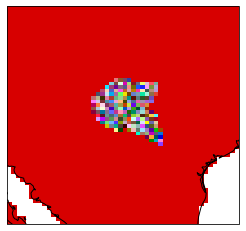

In [11]:
# Enumerate state vector elements
n_lat = len(new_lat_grid)
n_lon = len(new_lon_grid)
count = 1
for r in range(n_lat):
    for c in range(n_lon):
        if state_vector[r,c] == 1:
            state_vector[r,c] = count
            count += 1

# Now set pixels over water to NaN
if config['LandThreshold']:
    # Where there is no land, replace with NaN
    state_vector = state_vector.where(lc > config['LandThreshold'])
            
# Plot
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
state_vector.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cc.cm.glasbey,
    add_colorbar=False,
)
ax.coastlines();

## Label the buffer clusters

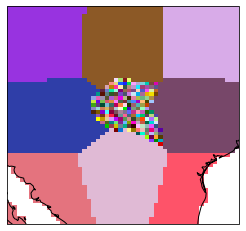

In [12]:
# Add buffer elements
buffer_elements = np.abs((mask > 0) - 1).values

# Get image coordinates of buffer elements
irows = np.arange(buffer_elements.shape[0])
icols = np.arange(buffer_elements.shape[1])
irows = np.transpose(np.tile(irows,(len(icols),1)))
icols = np.tile(icols,(len(irows),1)) * (buffer_elements > 0)

# Select image coordinates of buffer elements
irows_buffer = irows[buffer_elements > 0]
icols_buffer = icols[buffer_elements > 0]
coords = [[icols_buffer[j], irows_buffer[j]] for j in range(len(irows_buffer))]

# Kmeans based on image coordinates
X = np.array(coords)
kmeans = KMeans(n_clusters=config['nBufferClusters'], random_state=0).fit(X)

# Assign labels
for r in range(n_lat):
    for c in range(n_lon):
        if state_vector[r,c].values == 0:
            state_vector[r,c] = kmeans.predict([[c,r]])[0] + count

# Add units attribute
state_vector.attrs['units'] = 'none'
state_vector
            
# Plot
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
state_vector.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cc.cm.glasbey,
    add_colorbar=False,
)
ax.coastlines();

In [13]:
# Now set pixels over water to missing_value = -9999
if config['LandThreshold']:
    state_vector.values[state_vector.isnull()] = -9999

## Save the state vector to netcdf

In [14]:
# Create dataset
ds_state_vector = xr.Dataset(
                {
                    "StateVector": (["lat", "lon"], state_vector),
                },
                coords={
                    "lon": ("lon", new_lon_grid),
                    "lat": ("lat", new_lat_grid),
                },
                
                )

# Add attribute metadata
ds_state_vector.lat.attrs['units'] = 'degrees_north'
ds_state_vector.lat.attrs['long_name'] = 'Latitude'
ds_state_vector.lon.attrs['units'] = 'degrees_east'
ds_state_vector.lon.attrs['long_name'] = 'Longitude'
ds_state_vector.StateVector.attrs['units'] = 'none'
ds_state_vector.StateVector.attrs['missing_value'] = -9999
ds_state_vector.StateVector.attrs['_FillValue'] = -9999
ds_state_vector

<xarray.Dataset>
Dimensions:      (lat: 61, lon: 52)
Coordinates:
  * lon          (lon) float64 -110.9 -110.6 -110.3 ... -95.62 -95.31 -95.0
  * lat          (lat) float64 24.0 24.25 24.5 24.75 ... 38.25 38.5 38.75 39.0
Data variables:
    StateVector  (lat, lon) float64 204.0 204.0 204.0 ... 200.0 200.0 200.0

In [15]:
# Count elements
num_elements = int(state_vector.max().values)
print('State vector has',num_elements,'emission elements')

State vector has 207 emission elements


In [16]:
# Save
save = False # Switch to True if you wish to save the state vector file

if save:
    save_pth = config["StateVectorFile"]
    ds_state_vector.to_netcdf(save_pth)

----